# 误差
## 1. 训练误差和泛化误差
在机器学习中，通常假设训练数据集和测试数据集的每个样本都是从同一个概率分布中相互独立生成的。

基于独立同分布假设，训练误差和泛化误差是非常相近的，但往往$E(训练误差) <= E(泛化误差)$。

一般情况下，模型在训练集上的表现优于在测试集上的表现。一味降低训练误差并不意味着泛化误差会降低。

模型的选择应该关注泛化误差。

## 2. 模型选择
### 1. 验证数据集
预留一部分**验证数据集**进行模型选择（但是不参与模型训练），这些数据是在训练数据集和测试数据集以外。
### 2. K折交叉验证
1. 将原始训练数据集分成K个不重合的子数据集；
2. 然后做K次模型训练和验证，每次值选一个子数据集验证模型，其余的用作训练；
3. 最后，对K次训练误差和验证误差求平均。

## 3. 欠拟合和过拟合
1. 欠拟合：模型无法得到较低的训练误差
2. 过拟合：训练误差远远小于测试误差

主要有两个因素：模型复杂度，训练数据集大小

### 1. 模型复杂度
多项式函数拟合目标：
$$
\hat{y}=b+\sum_{k=1}^{K} x^{k} w_{k}
$$
给定训练数据集，如果模型 的复杂度过低，很容易易出现⽋拟合;如果模型复杂度过高，很容易出现过拟合。应对⽋拟合和过拟合的 ⼀个办法是针对数据集选择合适复杂度的模型。

### 2. 训练数据集大小
训练数据过少时，过拟合容易发生。训练数据增加与泛化误差没有必然联系，所以通常我们希望训练数据集大一些。

## 4. 多项式函数拟合实验
$$
y=1.2 x-3.4 x^{2}+5.6 x^{3}+5+\epsilon
$$

$\epsilon$是噪声，服从均值为0，标准差为0.01的正态分布

In [6]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import d2lzh_pytorch as d2l

In [7]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
# 多项式变量，系数均为1
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [8]:
features[:2], poly_features[:2], labels[:2]

(tensor([[0.5654],
         [1.9213]]), tensor([[0.5654, 0.3197, 0.1808],
         [1.9213, 3.6913, 7.0920]]), tensor([ 5.5967, 34.4852]))

In [9]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [10]:
num_epochs, loss = 100, torch.nn.MSELoss()

In [11]:
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Linear(train_features.shape[-1], 1)
    batch_size = min(10, train_labels.shape[0])
    dataset = Data.TensorDataset(train_features, train_labels)
    train_iter = Data.DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data, '\nbias:', net.bias.data)

final epoch: train loss 7.882608042564243e-05 test loss 0.0001330780505668372
weight: tensor([[ 1.2049, -3.3978,  5.5993]]) 
bias: tensor([4.9971])


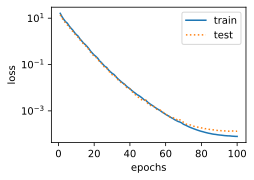

In [15]:
d2l.fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 99.1918716430664 test loss 51.50166320800781
weight: tensor([[15.1200]]) 
bias: tensor([2.1519])


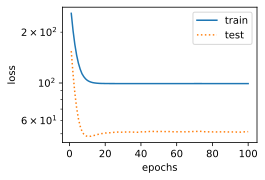

In [17]:
# 模拟下欠拟合，训练模型能力不足
# 训练模型是线性的，但是labels是三阶多项式的结果
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 0.5625312328338623 test loss 62.87388229370117
weight: tensor([[1.2955, 2.0614, 3.0836]]) 
bias: tensor([2.5895])


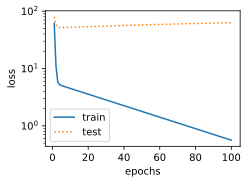

In [19]:
# 训练样本不足（过拟合）,训练效果太好了
fit_and_plot(poly_features[0:2, :], poly_features[n_train:,:], labels[0:2], labels[n_train:])